In [1]:
%load_ext autoreload
%autoreload 2
import sys
if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import asdict

from products.vanilla_option import VanillaOption
from models.model_params import LewisParams, MCParams, HestonParams, FractionalVolterraHestonParams, LiftedHestonParams
from models.heston import Heston
from models.fractional_volterra_heston import FractionalVolterraHeston
from models.lifted_heston import LiftedHeston
from utility.utility import from_delta_call_to_strike

/home/mr_giraffe/anaconda3/lib/python3.8/site-packages/py_lets_be_rational/numba_helper.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  return jit(*jit_args, **jit_kwargs)(fun)


### 1. All the models at the same place
- Heston
- Rough Heston
- Shifted Fractional Heston
- Lifted Heston

![image info](https://images.news18.com/ibnlive/uploads/2021/12/spiderman-meme-16401651614x3.png)

In [2]:
heston_params = HestonParams(V0=0.05, theta=0.06, lam=2, nu=0.6, rho=-0.4)
rough_params = FractionalVolterraHestonParams(**asdict(heston_params), H=0.1, eps=0)
shifted_params = FractionalVolterraHestonParams(**asdict(heston_params), H=0.1, eps=0.01)
lifted_params = LiftedHestonParams(**asdict(heston_params), H=0.1, n=20, r=2.5)

models = {
    "Heston": Heston(**asdict(heston_params)),
    "Rough": FractionalVolterraHeston(**asdict(rough_params)),
    "Shifted": FractionalVolterraHeston(**asdict(shifted_params)),
    "Lifted": LiftedHeston(**asdict(lifted_params))
}

### 2. Just smile

In [8]:
F0 = 100
T = 1
K = from_delta_call_to_strike(deltas = 1 - np.linspace(0.1, 0.9, 50), F0=F0, sigma=0.22, ttm=T)
k = np.log(K / F0)

option_call = VanillaOption(T=T, K=K, flag="call")

[]

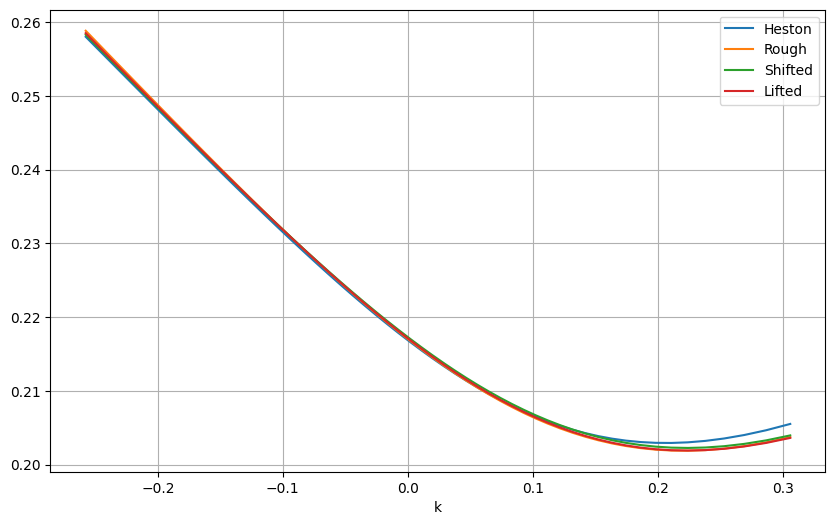

In [9]:
fig, ax = plt.subplots(figsize=(10,6))

for name, model in models.items():
    smile = option_call.get_price(model=model, method="lewis", F0=F0, is_vol_surface=True, 
                                  pricing_params=LewisParams(cf_timestep=0.001, N_points=25))
    ax.plot(k, smile, label=name)
    
ax.grid()
ax.legend()
ax.set_xlabel('k')
plt.plot()

### 3. Pricing time

#### Heston

In [14]:
%%timeit
smile = option_call.get_price(model=models["Heston"], method="lewis", F0=F0, is_vol_surface=True, 
                              pricing_params=LewisParams(cf_timestep=0.001, N_points=25))

5.86 ms ± 451 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Rough Heston

In [11]:
%%timeit
smile = option_call.get_price(model=models["Rough"], method="lewis", F0=F0, is_vol_surface=True, 
                              pricing_params=LewisParams(cf_timestep=0.001, N_points=25))

447 ms ± 39.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Shifted Fractional Heston

In [12]:
%%timeit
smile = option_call.get_price(model=models["Shifted"], method="lewis", F0=F0, is_vol_surface=True, 
                              pricing_params=LewisParams(cf_timestep=0.001, N_points=25))

478 ms ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Lifted Heston

In [15]:
%%timeit
smile = option_call.get_price(model=models["Lifted"], method="lewis", F0=F0, is_vol_surface=True, 
                              pricing_params=LewisParams(cf_timestep=0.001, N_points=25))

20.2 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### 4. ATM Skew

$$
\psi(T) := \left| \dfrac{\partial \sigma_{\mathrm{BS}}(T, k)}{\partial k}\right| \Bigg|_{k = 0}
 \approx \left|\dfrac{\sigma_{\mathrm{IV}}(T, \log(1 + \epsilon)) - \sigma_{\mathrm{IV}}(T, \log(1 - \epsilon))}{\log(1 + \epsilon) - \log(1 - \epsilon)}\right|
$$
with $\epsilon = 0.05$.

In [16]:
def plot_atm_skew(model, T_grid, bump=0.03, ax=None, **kwargs):
    K_skew = np.array([1 - bump, 1 + bump])
    k_skew = np.log(K_skew)

    option_call_skew = VanillaOption(T=T_grid, K=K_skew, flag="call")

    smile_skew = option_call_skew.get_price(model=model, method="lewis", F0=1, is_vol_surface=True, 
                                            pricing_params=LewisParams(cf_timestep=0.0001, N_points=25))

    atm_skew = -(np.diff(smile_skew, axis=1) / np.diff(k_skew)).squeeze()

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(T_grid, atm_skew, **kwargs)
    ax.grid("on")
    ax.set_xlabel("T")
    ax.set_title("ATM skew")

CPU times: user 8min 2s, sys: 1.75 s, total: 8min 4s
Wall time: 1min 21s


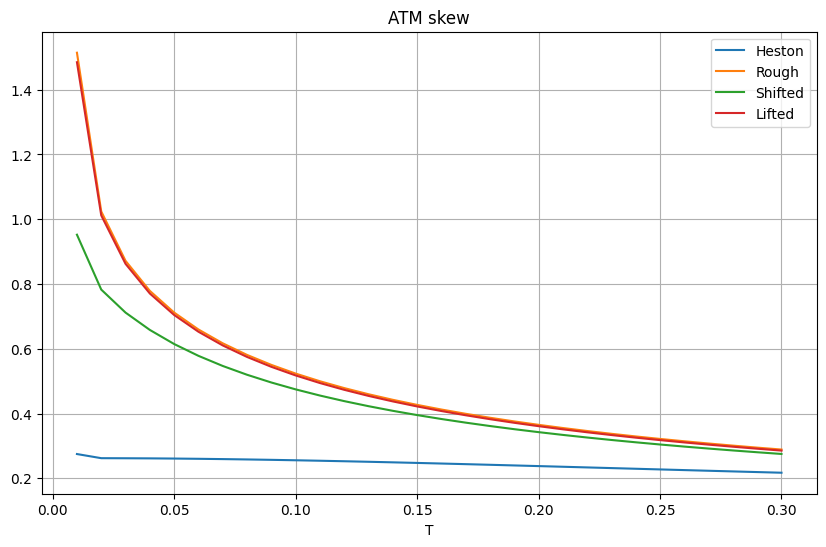

In [17]:
%%time

fig, ax = plt.subplots(figsize=(10,6))

T_skew = np.linspace(0.01, 0.3, 30)

for name, model in models.items():
    plot_atm_skew(model, T_grid=T_skew, ax=ax, label=name)
    
ax.legend()

### 5. Roughness estimation: Lifted Heston

#### Variance and factors trajectories

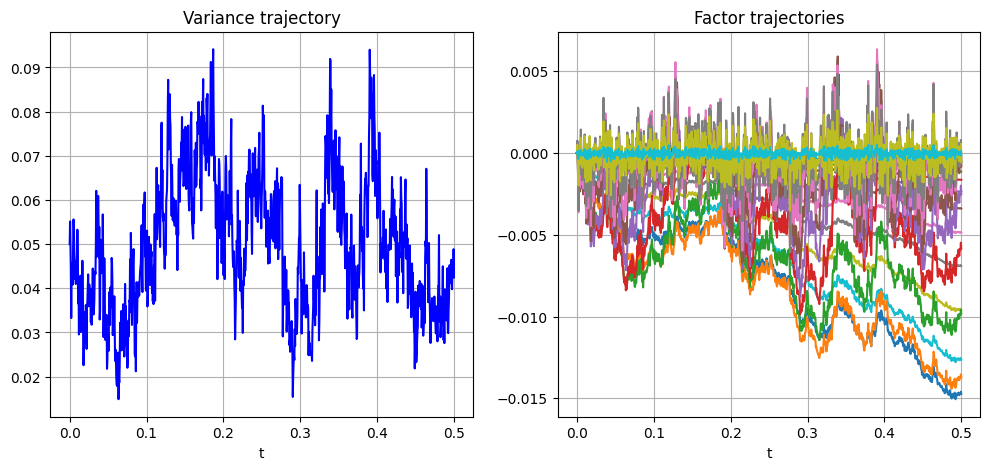

In [18]:
size = 1
N_grid = 1000
T = 0.5
F0 = 100

t_grid = np.linspace(0, T, N_grid)
rng = np.random.default_rng(seed=43)

models["Lifted"].nu = 0.1

V, U = models["Lifted"].get_variance_trajectory(t_grid=t_grid, size=size, rng=rng, return_factors=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(t_grid, V.squeeze(), "b")
for i in range(len(models["Lifted"].x))[::]:
    ax[1].plot(t_grid, models["Lifted"].c[i] * U[0, i, :])

ax[0].set_xlabel("t")
ax[1].set_xlabel("t")
ax[0].set_title("Variance trajectory")
ax[1].set_title("Factor trajectories")
ax[0].grid()
ax[1].grid()

#### Roughness estimation

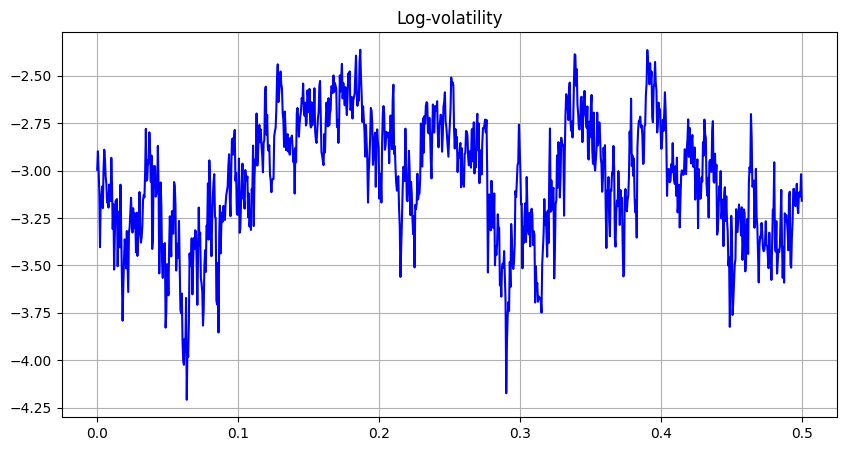

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(t_grid, np.log(V.squeeze()), "b")
ax.set_title("Log-volatility")
ax.grid()

In [20]:
from roughness.hurst_estimation import m_estimator

0.18907969641608718

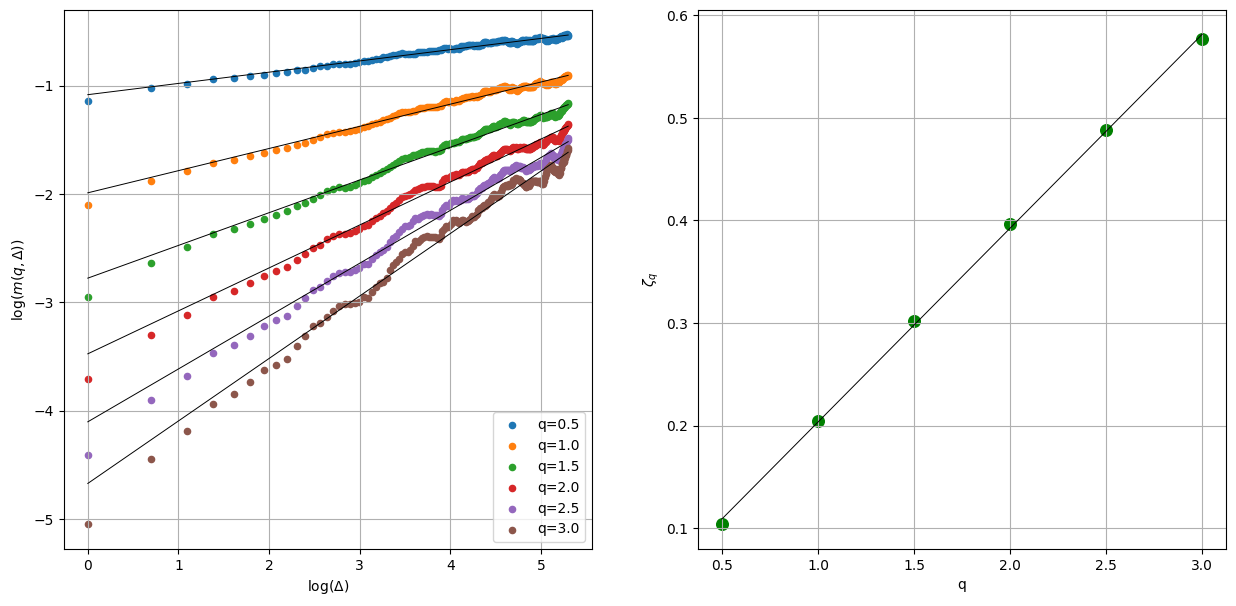

In [21]:
m_estimator(np.log(V.squeeze()), is_plotting=True, intersect=True, steps=np.arange(1, 201))